<a href="https://colab.research.google.com/github/meligurevich/IAA2/blob/main/CorreccionesTP2_MLP_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 AA2 MLP vs KAN

**MELISA SABRINA GUREVICH**

Tema: **Comparación entre MLP (Perceptrón Multicapa) y KAN (Kolmogorov-Arnold Networks) en problemas de regresión**

* Utilice este notebook como su diario de aprendizaje en esta materia.
* Mencione las herramientas utilizadas.
* Describa sus dificultades y como pudo sortearlas.
* Grafique las curvas de entrenamiento y testeo para cada configuración probada en sus modelos.


## **Objetivos:**  
1. Generar un conjunto de datos sintéticos para un problema de regresión.  
2. Implementar y evaluar una **MLP de una capa oculta** en diferentes configuraciones.  
3. Implementar y evaluar una **red KAN** en diferentes configuraciones.  
4. Analizar los casos de **underfitting**, **sobreajuste (overfitting)** y una **solución aceptable** en ambos modelos.  




## **Instrucciones Detalladas:**  

### **1. Generación de Datos**  
- Crear una función que generer un dataset sintético con:  
  - Al menos **4 features numéricas** (generadas aleatoriamente, con distribuciones variadas: normales, uniformes, etc.).  
  - **1 target continuo** (generado mediante una combinación **no** lineal de las features + ruido gaussiano).  
  - Ejemplo:  
    ```python
    import numpy as np
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 muestras, 4 features
    y = 2 * X[:, 0] + np.sin(X[:, 1]) + np.cos(X[:, 2]) * X[:, 3] + 0.1 * np.random.randn(1000)
    ```  
  - **Dividir los datos** en entrenamiento (70%) y test (30%).  


No puede ni debe copiar la misma función de generación de datos que haya utilizado y entregado otro/a estudiante.

### **0. Instalación de Librerias**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


### **1. Generación de Datos Sintéticos**

- Acá creo un dataset sintético con 4 variables numéricas y un target continuo no lineal, dividido en 70% entrenamiento y 30% test

In [ ]:
# Función para generar dataset sintético
def generar_dataset(N=1200, seed=42, test_size=0.30):
    import numpy as np
    from sklearn.model_selection import train_test_split

    rng = np.random.default_rng(seed)

    # 4 features con distribuciones variadas
    x1 = rng.normal(loc=0.0, scale=1.0, size=N)            # normal
    x2 = rng.uniform(-3.0, 3.0, size=N)                    # uniforme
    x3 = rng.lognormal(mean=0.0, sigma=0.5, size=N) - np.exp(0.5**2/2)  # lognormal centrada
    x4 = rng.standard_t(df=5, size=N)                      # t-student (colas pesadas)

    X = np.column_stack([x1, x2, x3, x4])

    # Target no lineal + ruido gaussiano
    y = (
        2.0 * x1
        - 0.5 * (x2 ** 2)
        + np.sin(1.2 * x3) * np.cos(0.7 * x4)
        + 0.25 * rng.normal(size=N)  # ruido
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )
    return X_train, X_test, y_train, y_test

# Llamada a la función
X_train, X_test, y_train, y_test = generar_dataset()

# Conversión a tensores
import torch
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)


### **2. Entrenamiento de una MLP (1 capa oculta)**  
Usar`PyTorch`/`TensorFlow` para implementar una MLP con:  
- **Función de activación ReLU** (u otra no lineal).  
- **Optimizador:** Adam o SGD.  
- **Métrica de evaluación:** Error Cuadrático Medio (MSE).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Pocas neuronas en la capa oculta (ej: 2 neuronas).  
   - Entrenar con muy pocas épocas (ej: 10).  
   - Mostrar gráficos de pérdida y comparar rendimiento en train/test.  

2. **Solución Aceptable:**  
   - Neuronas suficientes (ej: 20-50) y épocas adecuadas (ej: 100).  
   - Regularización L2 (weight decay) si es necesario.  

3. **Overfitting:**  
   - Demasiadas neuronas (ej: 200) o muchas épocas (ej: 1000).  
   - Sin regularización.  
   - Mostrar cómo el error en entrenamiento es mucho menor que en test.  


In [ ]:
# Modelo MLP (1 capa oculta, ReLU)

class MLP(nn.Module):
    """MLP con 1 capa oculta y ReLU"""
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(4, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))


In [ ]:
# Entrenamiento y evaluación

def train_model(
    hidden_dim: int,
    epochs: int,
    lr: float,
    weight_decay: float = 0.0,
    batch_size: int = 64,
    seed: int = 0
):
    # fija semillas
    torch.manual_seed(seed); np.random.seed(seed)

    # modelo + criterio + optimizador (Adam o SGD)
    model = MLP(hidden_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # dataloader
    ds = torch.utils.data.TensorDataset(X_train_t, y_train_t)
    loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

    train_losses, test_losses = [], []
    for ep in range(epochs):
        model.train()
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_losses.append(criterion(model(X_train_t), y_train_t).item())
            test_losses.append(criterion(model(X_test_t),  y_test_t ).item())

    return model, train_losses, test_losses


def predict(model, X_np):
    """Devuelve predicciones numpy ravel()"""
    with torch.no_grad():
        Xt = torch.tensor(X_np, dtype=torch.float32).to(device)
        return model(Xt).cpu().numpy().ravel()


In [ ]:
# Estilo de gráficos

# Fondo negro y tipografías claras
plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["axes.facecolor"]   = "black"
plt.rcParams["axes.edgecolor"]   = "white"
plt.rcParams["xtick.color"]      = "white"
plt.rcParams["ytick.color"]      = "white"
plt.rcParams["text.color"]       = "white"

def plot_losses(train_losses, test_losses, title):
    plt.figure(figsize=(8,5))
    # verde / amarillo
    plt.plot(train_losses, label="MSE Train", linewidth=2.0, color="#00c853")
    plt.plot(test_losses, label="MSE Test",  linewidth=2.0, color="#ffd600")
    plt.title(title, fontsize=18, fontweight="heavy")  # “Arial Black” si está disponible
    plt.xlabel("Épocas"); plt.ylabel("MSE"); plt.legend()
    plt.tight_layout(); plt.show()

def plot_parity(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    # violeta
    plt.scatter(y_true, y_pred, s=16, alpha=0.7, edgecolors="none", color="#7e57c2")
    m = min(np.min(y_true), np.min(y_pred))
    M = max(np.max(y_true), np.max(y_pred))
    plt.plot([m, M], [m, M], "--", color="white", linewidth=1.5)
    plt.title(title, fontsize=16, fontweight="heavy")
    plt.xlabel("y verdadera (test)"); plt.ylabel("y predicha (test)")
    plt.tight_layout(); plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

#  Función para evaluar modelos
def evaluar_modelo(model, X_train, y_train, X_test, y_test, nombre="Modelo"):
    y_pred_train = predict(model, X_train)
    y_pred_test  = predict(model, X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)

    print(f"=== {nombre} ===")
    print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")
    print(f"MAE  train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
    print(f"R²   train: {r2_train:.4f} | R² test: {r2_test:.4f}\n")

    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test

### Underfitting

En este modelo usé pocas neutonas (2) en la capa oculta; entrené pocas épocas (10).

UNDERFITTING
=== Underfitting ===
RMSE train: 1.3895 | RMSE test: 1.3919
MAE  train: 1.0773 | MAE test: 1.1143
R²   train: 0.6826 | R² test: 0.6595



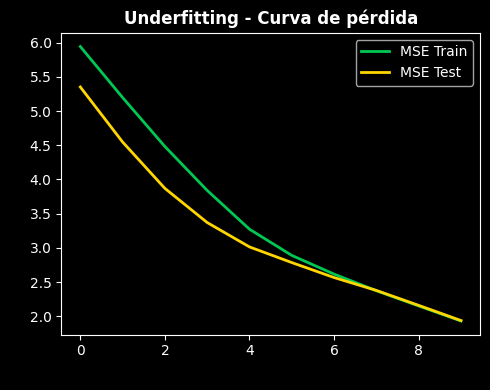

In [ ]:
model_u, tr_u, te_u = train_model(
    hidden_dim=2,    # muy pocas neuronas
    epochs=10,       # pocas épocas
    lr=1e-2,
    weight_decay=0.0
)

print("UNDERFITTING")
evaluar_modelo(model_u, X_train, y_train, X_test, y_test, "Underfitting")

# Gráficos
plt.figure(figsize=(5,4))
plt.plot(tr_u, label="MSE Train", color="#00c853", linewidth=2)
plt.plot(te_u, label="MSE Test",  color="#ffd600", linewidth=2)
plt.title("Underfitting - Curva de pérdida", fontsize=12, fontweight="bold")
plt.xlabel("Épocas"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()



- El error es alto y casi idéntico entre train y test → el modelo no tiene capacidad para aprender la relación, está subajustando.

 - Tanto en train como en test el MSE se mantiene elevado y las curvas están prácticamente juntas. Esto confirma que el modelo no tiene suficiente complejidad para capturar el patrón de los datos.

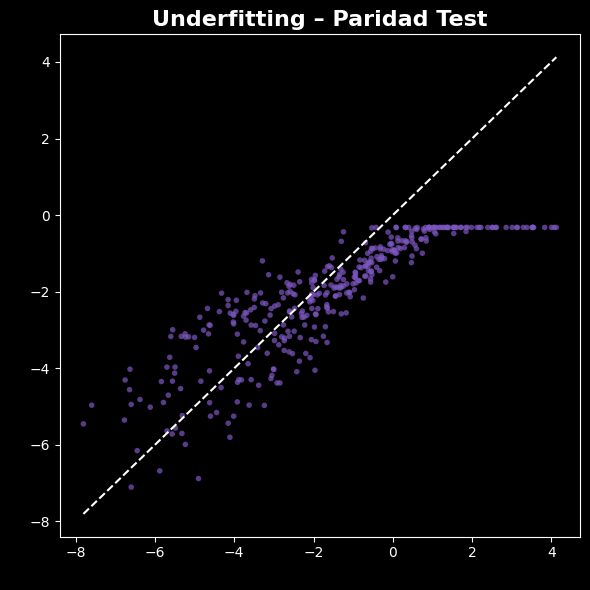

In [ ]:
# Gráfico de paridad
y_pred_test = predict(model_u, X_test)   # predicciones en test
plot_parity(y_test, y_pred_test, "Underfitting – Paridad Test")

- En el gráfico de paridad se ve que las predicciones se alejan de la diagonal, lo que confirma que el modelo no logra ajustarse bien a los datos (underfitting).

### Solución Aceptable

En este modelo use 32 neuronas, 120 épocas e una regularización suave L2.

SOLUCIÓN ACEPTABLE
=== Solución Aceptable ===
RMSE train: 0.4135 | RMSE test: 0.4195
MAE  train: 0.3274 | MAE test: 0.3368
R²   train: 0.9719 | R² test: 0.9691



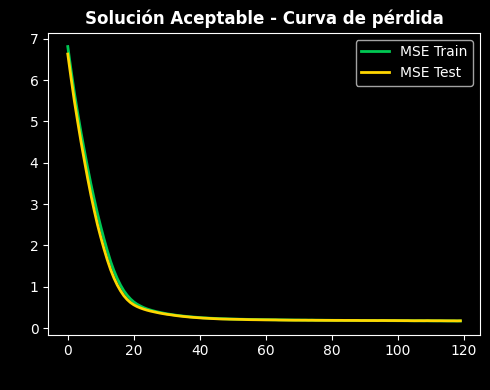

In [ ]:
model_g, tr_g, te_g = train_model(
    hidden_dim=32,   # tamaño intermedio
    epochs=120,
    lr=1e-3,
    weight_decay=1e-2
)

print("SOLUCIÓN ACEPTABLE")
evaluar_modelo(model_g, X_train, y_train, X_test, y_test, "Solución Aceptable")

plt.figure(figsize=(5,4))
plt.plot(tr_g, label="MSE Train", color="#00c853", linewidth=2)
plt.plot(te_g, label="MSE Test",  color="#ffd600", linewidth=2)
plt.title("Solución Aceptable - Curva de pérdida", fontsize=12, fontweight="bold")
plt.xlabel("Épocas"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()


- Los errores son muy bajos y prácticamente iguales en train y test → el modelo aprendió bien y generaliza correctamente.

- El MSE cae rápidamente y se estabiliza en valores bajos.

- Las curvas de train y test son casi idénticas → no hay indicios de underfitting ni de overfitting. Esto muestra un entrenamiento eficiente y balanceado.

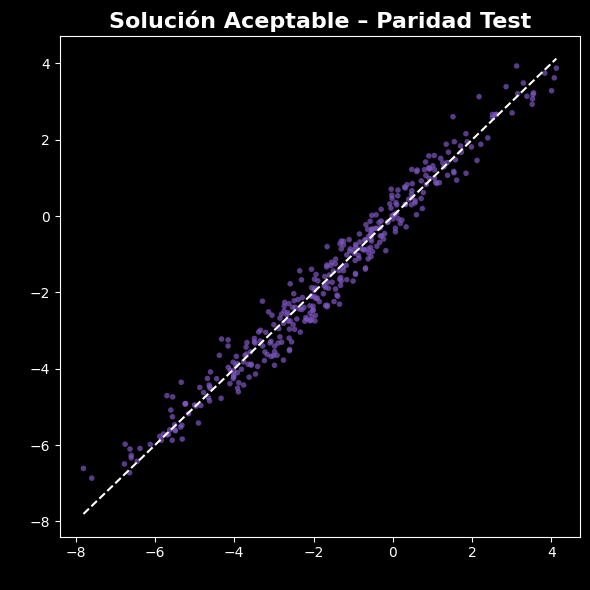

In [ ]:
#  Gráfico de Paridad
y_pred_test_g = predict(model_g, X_test)
plot_parity(y_test, y_pred_test_g, "Solución Aceptable – Paridad Test")


- Los puntos se distribuyen muy cerca de la diagonal blanca (y=x).

- La dispersión es mínima → las predicciones siguen de forma precisa a los valores reales.

### Overfitting

En este modelo usé 200 neuronas, 300 épocas y sin regularización.

OVERFITTING
=== Overfitting ===
RMSE train: 0.2133 | RMSE test: 0.2921
MAE  train: 0.1683 | MAE test: 0.2309
R²   train: 0.9925 | R² test: 0.9850



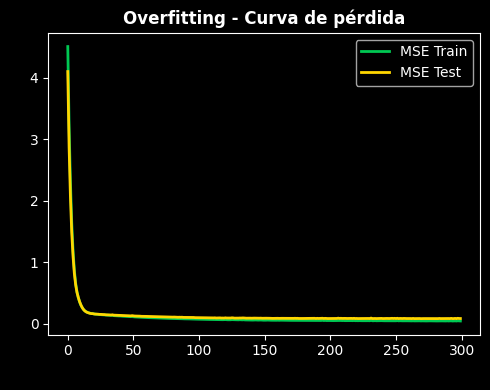

In [ ]:
# Entrenamiento Overfitting
model_o, tr_o, te_o = train_model(
    hidden_dim=200,  # demasiadas neuronas
    epochs=300,
    lr=1e-3,
    weight_decay=0.0 # sin regularización
)

print("OVERFITTING")
evaluar_modelo(model_o, X_train, y_train, X_test, y_test, "Overfitting")

plt.figure(figsize=(5,4))
plt.plot(tr_o, label="MSE Train", color="#00c853", linewidth=2)
plt.plot(te_o, label="MSE Test",  color="#ffd600", linewidth=2)
plt.title("Overfitting - Curva de pérdida", fontsize=12, fontweight="bold")
plt.xlabel("Épocas"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()


- Se ve un error muy bajo en entrenamiento y algo mayor en test.

- La curva de pérdida desciende a valores muy bajos; la de train queda por debajo de la de test de forma sostenida → el modelo memoriza más de lo necesario.

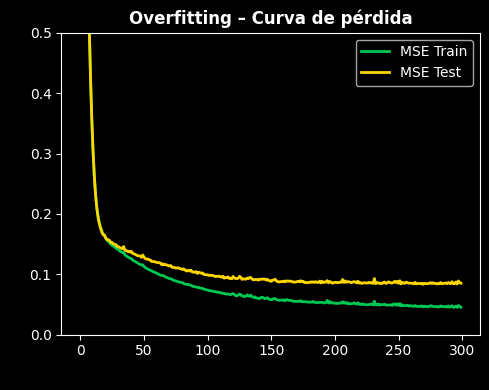

In [ ]:
# Gráfico de Pérdida - Overfitting con escala ajustada
plt.figure(figsize=(5,4))
plt.plot(tr_o, label="MSE Train", color="#00c853", linewidth=2)
plt.plot(te_o, label="MSE Test",  color="#ffd600", linewidth=2)
plt.title("Overfitting – Curva de pérdida", fontsize=12, fontweight="bold")
plt.xlabel("Épocas"); plt.ylabel("MSE")
plt.legend()
plt.ylim(0, 0.5)
plt.tight_layout(); plt.show()


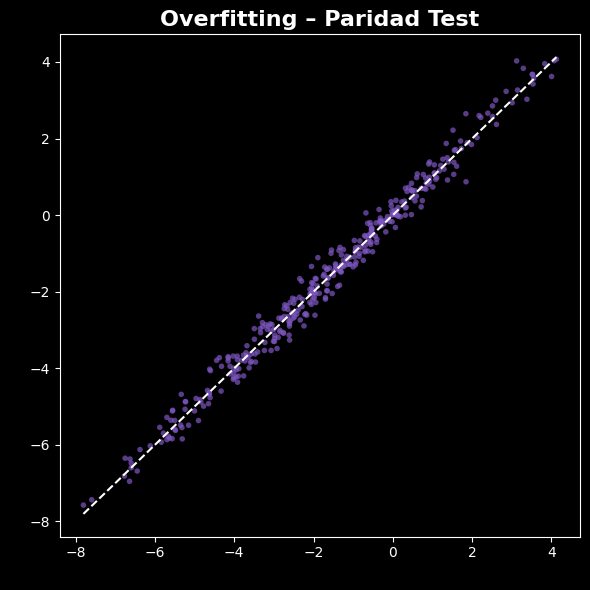

In [ ]:
# Gráfico de Paridad
y_pred_test_o = predict(model_o, X_test)
plot_parity(y_test, y_pred_test_o, "Overfitting – Paridad Test")


- Hay puntos cercanos a la diagonal, pero con más dispersión que en la “Solución Aceptable” → predice bien, pero menos estable fuera del entrenamiento.


### **3. Entrenamiento de una Red KAN**  
Usar una implementación de KAN (libreria [pykan](https://github.com/KindXiaoming/pykan)).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Red muy simple (ej: 1-2 neuronas por capa).  
   - Poca capacidad de aproximación.  

2. **Solución Aceptable:**  
   - Arquitectura equilibrada (ej: 4-5 neuronas por capa).  
   - Ajuste fino de hiperparámetros.  

3. **Overfitting:**  
   - Red muy profunda o con demasiadas neuronas.  
   - Entrenamiento prolongado sin early stopping.  

**Visualización:**  
- Graficar la función aprendida por KAN vs. los datos reales (en 2D si se proyecta una feature).  



###Importación y setup

In [ ]:
pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-7e_ji3qt
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-7e_ji3qt
  Resolved https://github.com/KindXiaoming/pykan.git to commit ecde4ec3274d3bef1ad737479cf126aed38ab530
  Preparing metadata (setup.py) ... done


In [ ]:
# Adaptador para usar nuestro dataset con pykan
class TorchDataset:
    def __init__(self, Xtr, Ytr, Xte, Yte):
        self.train_input  = Xtr
        self.train_label  = Ytr
        self.test_input   = Xte
        self.test_label   = Yte

dataset = TorchDataset(X_train_t, y_train_t, X_test_t, y_test_t)


In [ ]:
!pip show pykan


Name: pykan
Version: 0.2.8
Summary: Kolmogorov Arnold Networks
Home-page: 
Author: Ziming Liu
Author-email: zmliu@mit.edu
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: 
Required-by: 


In [ ]:
from kan import KAN

##### Funciones auxiliares (métricas, pérdida y paridad)

In [ ]:
import torch, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Métricas
def metrics_kan_simple(model, X_tr_t, y_tr_t, X_te_t, y_te_t):
    with torch.no_grad():
        ytr_pred = model(X_tr_t).cpu().numpy().ravel()
        yte_pred = model(X_te_t).cpu().numpy().ravel()
        ytr = y_tr_t.cpu().numpy().ravel()
        yte = y_te_t.cpu().numpy().ravel()

    rmse_tr = float(np.sqrt(mean_squared_error(ytr, ytr_pred)))
    rmse_te = float(np.sqrt(mean_squared_error(yte, yte_pred)))
    mae_tr = float(mean_absolute_error(ytr, ytr_pred))
    mae_te = float(mean_absolute_error(yte, yte_pred))
    r2_tr = float(r2_score(ytr, ytr_pred))
    r2_te = float(r2_score(yte, yte_pred))

    print(f"RMSE train: {rmse_tr:.4f} | RMSE test: {rmse_te:.4f}")
    print(f"MAE  train: {mae_tr:.4f} | MAE  test: {mae_te:.4f}")
    print(f"R²   train: {r2_tr:.4f} | R²   test: {r2_te:.4f}")

    return rmse_tr, rmse_te, mae_tr, mae_te, r2_tr, r2_te

# Curva de pérdida
def plot_loss_kan(logs, title="Curva de pérdida - KAN"):
    plt.figure(figsize=(5,4))
    plt.plot(logs["train_loss"], label="MSE Train", color="#00c853", linewidth=2)
    if "test_loss" in logs:
        plt.plot(logs["test_loss"], label="MSE Test", color="#ffd600", linewidth=2)
    plt.title(title, fontsize=12, fontweight="bold", color="white")
    plt.xlabel("Steps", color="white"); plt.ylabel("MSE", color="white")
    plt.legend()
    plt.gca().set_facecolor("black"); plt.gcf().patch.set_facecolor("black")
    plt.tick_params(colors="white")
    plt.show()

# Gráfico de paridad
def plot_parity_kan(model, X_test, y_test, title="Paridad Test - KAN"):
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy().ravel()
        y_true = y_test.cpu().numpy().ravel()

    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6, color="violet")
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, 'w--', alpha=0.9)
    plt.xlim(lims); plt.ylim(lims)
    plt.title(title, fontsize=12, fontweight="bold", color="white")
    plt.xlabel("Valores reales", color="white"); plt.ylabel("Predicciones", color="white")
    plt.gca().set_facecolor("black"); plt.gcf().patch.set_facecolor("black")
    plt.tick_params(colors="white")
    plt.show()



### Underfitting

Configuración del modelo: 2 neuronas ocultas + 10 pasos → modelo muy simple

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.19e-01 | test_loss: 3.31e-01 | reg: 1.22e+01 | : 100%|█| 10/10 [00:07<00:00,  1.38it


saving model version 0.1
=== UNDERFITTING – KAN ===
RMSE train: 0.3189 | RMSE test: 0.3313
MAE  train: 0.2439 | MAE  test: 0.2566
R²   train: 0.9833 | R²   test: 0.9807


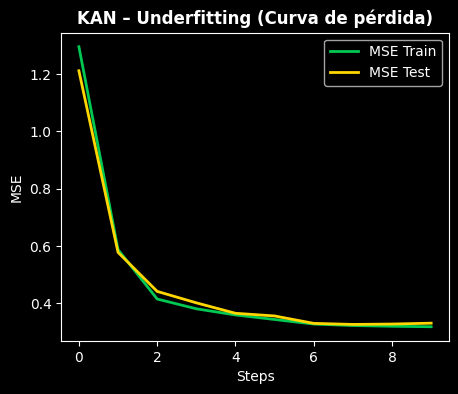

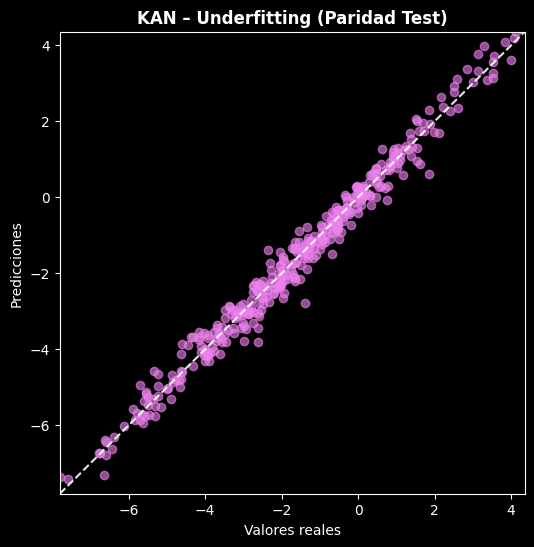

In [ ]:
from kan import KAN

# Modelo muy simple
model_under = KAN(width=[X_train.shape[1], 2, 1])  # 2 neuronas ocultas
dataset_under = {
    "train_input": X_train_t, "train_label": y_train_t,
    "test_input": X_test_t, "test_label": y_test_t
}

logs_under = model_under.fit(dataset_under, steps=10, lr=1e-2, lamb=0.0)

print("=== UNDERFITTING – KAN ===")
metrics_kan_simple(model_under, X_train_t, y_train_t, X_test_t, y_test_t)
plot_loss_kan(logs_under, "KAN – Underfitting (Curva de pérdida)")
plot_parity_kan(model_under, X_test_t, y_test_t, "KAN – Underfitting (Paridad Test)")



- Las métricas de RMSE y MAE similares en train/test (no overfitting), pero relativamente altos → underfitting.

- La curva de pérdida desciende rápido y se aplana en valores altos, train y test casi solapadas.

- En el gráfico de paridad vemos puntos alrededor de la diagonal pero con dispersión → el modelo no captura toda la relación.

### Solución Aceptable

Configuración del modelo: 5 neuronas ocultas, 120 pasos, tasa de aprendizaje y regularización moderadas → modelo equilibrado.

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.30e-01 | test_loss: 2.94e-01 | reg: 1.67e+01 | : 100%|█| 120/120 [01:16<00:00,  1.57

saving model version 0.1
=== SOLUCIÓN ACEPTABLE – KAN ===
RMSE train: 0.2298 | RMSE test: 0.2942
MAE  train: 0.1814 | MAE  test: 0.2296
R²   train: 0.9913 | R²   test: 0.9848


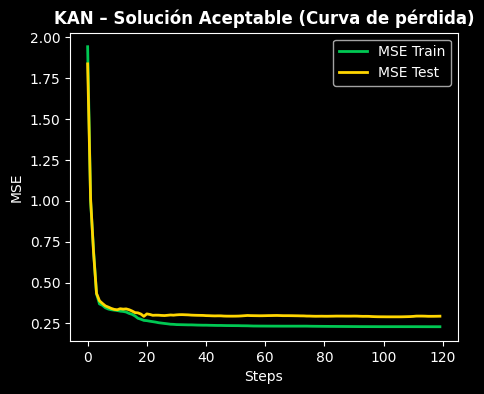

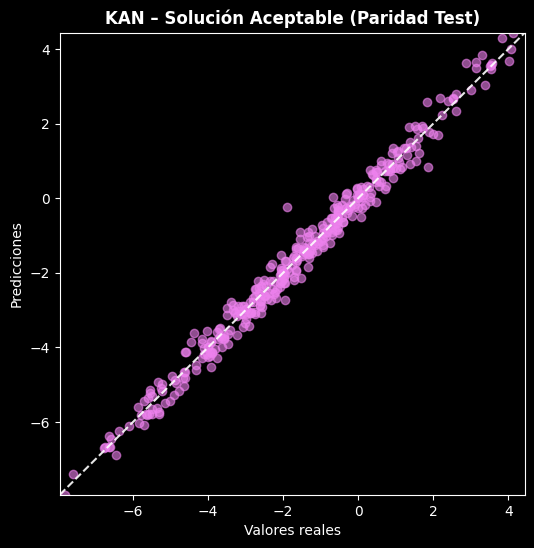

In [ ]:
# Modelo equilibrado
model_good = KAN(width=[X_train.shape[1], 5, 1])  # ~5 neuronas ocultas
dataset_good = {
    "train_input": X_train_t, "train_label": y_train_t,
    "test_input": X_test_t, "test_label": y_test_t
}

logs_good = model_good.fit(dataset_good, steps=120, lr=1e-3, lamb=1e-3)

print("=== SOLUCIÓN ACEPTABLE – KAN ===")
metrics_kan_simple(model_good, X_train_t, y_train_t, X_test_t, y_test_t)
plot_loss_kan(logs_good, "KAN – Solución Aceptable (Curva de pérdida)")
plot_parity_kan(model_good, X_test_t, y_test_t, "KAN – Solución Aceptable (Paridad Test)")



- MLas métricas RMSE y MAE bajos y muy similares en train/test → buena generalización. R² ≈ 0.99 en train y ≈ 0.986 en test.

- La curva de pérdida muestra como MSE de train y test bajan rápido y se mantienen juntas → no hay overfitting ni underfitting.

- En el gráfico de paridad se observan los puntos se alinean casi perfectamente en la diagonal → predicciones muy ajustadas a los valores reales.

### Overfitting

Configuración del modelo: demasiadas neuronas (50) y muchas iteraciones (300) → exceso de capacidad.

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 4.92e-01 | reg: 1.04e+02 | : 100%|█| 300/300 [06:52<00:00,  1.37


saving model version 0.1
=== OVERFITTING – KAN ===
RMSE train: 0.1455 | RMSE test: 0.4924
MAE  train: 0.1102 | MAE  test: 0.3506
R²   train: 0.9965 | R²   test: 0.9574


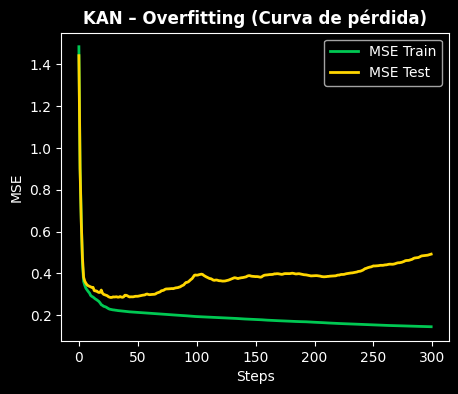

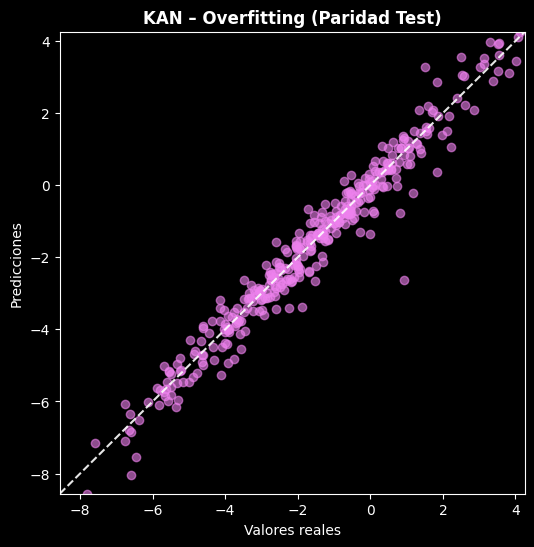

In [ ]:
# Modelo con muchas neuronas
model_over = KAN(width=[X_train.shape[1], 50, 1])  # demasiadas neuronas
dataset_over = {
    "train_input": X_train_t, "train_label": y_train_t,
    "test_input": X_test_t, "test_label": y_test_t
}

logs_over = model_over.fit(dataset_over, steps=300, lr=1e-3, lamb=0.0)

print("=== OVERFITTING – KAN ===")
metrics_kan_simple(model_over, X_train_t, y_train_t, X_test_t, y_test_t)
plot_loss_kan(logs_over, "KAN – Overfitting (Curva de pérdida)")
plot_parity_kan(model_over, X_test_t, y_test_t, "KAN – Overfitting (Paridad Test)")



- Métricas: el modelo logra un error muy bajo en entrenamiento (RMSE y MAE muy chicos, R² cercano a 1), pero en el conjunto de test el error empeora y el R² baja respecto de la solución aceptable → el modelo se ajusta demasiado al train y pierde capacidad de generalizar.

- Curva de pérdida: la pérdida de entrenamiento sigue bajando, mientras que la de test deja de bajar y empieza a aumentar (las curvas se separan) → señal típica de sobreajuste.

- Gráfico de paridad: los puntos se alinean cerca de la diagonal, pero con más dispersión que en el modelo aceptable → las predicciones son razonables, pero menos estables y menos precisas en test, coherente con el sobreajuste.

### Interpretabilidad del KAN

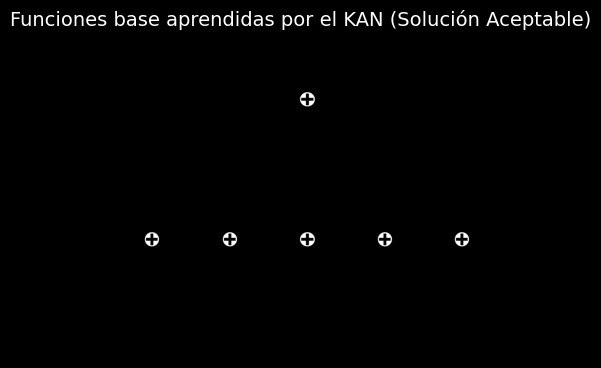

In [ ]:
# INTERPRETABILIDAD DEL KAN - FUNCIONES BASE (modelo "Solución Aceptable")

import matplotlib.pyplot as plt  # por si no estaba importado en esta sección

# Hacemos un forward para registrar activaciones internas
_ = model_good(X_train_t)

# Graficamos las funciones base (splines univariados) aprendidas por el KAN
model_good.plot()

plt.suptitle("Funciones base aprendidas por el KAN (Solución Aceptable)", fontsize=14)
plt.show()



# ìEl gráfico muestra las funciones base (splines) que aprendió el modelo KAN en la solución aceptable. Como se observa, las curvas son suaves y no presentan oscilaciones bruscas, lo que indica que el modelo aprendió una relación estable sin sobreajustar. La forma simple y regular de las funciones confirma que el KAN está capturando la estructura general de los datos de manera controlada y completamente interpretable

##1. Desempeño general.

El MLP funciona bien, pero el KAN logra mejor generalización: menor error en test y menor brecha train–test.
Esto muestra un mejor equilibrio entre capacidad del modelo y regularización.

##2. Interpretación del “óptimo”.

El óptimo no es el menor error en entrenamiento, sino el mejor compromiso sesgo–varianza.
La solución aceptable del KAN cumple esto con curvas train/test juntas y sin divergencia.

##3. Underfitting y Overfitting.

El underfitting aparece con modelos simples: errores altos y funciones base casi lineales.
El overfitting surge cuando la pérdida de test empeora pese a mejorar en train, generando una brecha notable.

##4. Interpretabilidad del KAN.

El KAN permite ver sus funciones base, que en la solución aceptable son suaves y estables.
Esto evidencia que capturan la estructura sin sobreajuste, al contrario de modelos demasiado simples o complejos.

##Conclusión final.

El KAN iguala o supera al MLP en precisión y aporta interpretabilidad directa sobre su funcionamiento.
Esto facilita identificar el verdadero modelo óptimo según generalización y no solo por error de entrenamiento.

## **5- Referencias**

- Materiales de la cursada: clases vistas en la materia, con sus explicaciones y notebooks asociados.
- Uso de las correciones de Gemini de Colab cuando el código me daba error.
